# Notebook for analysis of engineering-colleges-in-india

## Done by Shrirang Mhalgi

In [327]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from fuzzywuzzy import fuzz
from pathlib import Path
import mysql.connector
from tqdm import tqdm

In [2]:
# reading the dataset
engg_colleges = pd.read_csv("../datasets/indian_universities.csv")

In [3]:
# getting the shape of the dataset
engg_colleges.shape

(5440, 15)

In [4]:
engg_colleges.describe()

Total Student Enrollments  Total Faculty  Established Year      Rating  \
count               4.437000e+03    5279.000000       5339.000000  327.000000   
mean                1.915446e+03      96.739345       2000.425548    3.081896   
std                 1.841858e+04     113.869962         16.203044    0.305166   
min                 1.000000e+00       1.000000       1857.000000    2.010000   
25%                 4.090000e+02      37.000000       1998.000000    3.010000   
50%                 8.120000e+02      69.000000       2007.000000    3.100000   
75%                 1.551000e+03     124.000000       2009.000000    3.235000   
max                 1.035081e+06    2453.000000       2019.000000    3.830000   

       Average Fees  
count  5.440000e+03  
mean   1.886011e+05  
std    1.807647e+05  
min    1.800000e+02  
25%    9.000000e+04  
50%    1.590000e+05  
75%    2.400000e+05  
max    3.578597e+06

In [5]:
# checking for null values
engg_colleges.isna().sum()

College Name                    0
Genders Accepted               18
Campus Size                  2751
Total Student Enrollments    1003
Total Faculty                 161
Established Year              101
Rating                       5113
University                   1936
Courses                         0
Facilities                     12
City                            0
State                           0
Country                         0
College Type                    1
Average Fees                    0
dtype: int64

In [6]:
# checking for data types of the columns
engg_colleges.dtypes

College Name                  object
Genders Accepted              object
Campus Size                   object
Total Student Enrollments    float64
Total Faculty                float64
Established Year             float64
Rating                       float64
University                    object
Courses                       object
Facilities                    object
City                          object
State                         object
Country                       object
College Type                  object
Average Fees                 float64
dtype: object

In [7]:
engg_colleges.head()

College Name Genders Accepted  \
0         National Institute of Technology Rourkela             Co-Ed   
1  Visvesvaraya National Institute of Technology ...            Co-Ed   
2             Netaji Subhas University of Technology            Co-Ed   
3                      Birla Institute of Technology            Co-Ed   
4  International Institute of Information Technology            Co-Ed   

  Campus Size  Total Student Enrollments  Total Faculty  Established Year  \
0   647 Acres                     4811.0          329.0            2007.0   
1   215 Acres                     1071.0          192.0            2007.0   
2   145 Acres                     3759.0          101.0            2018.0   
3   980 Acres                     4506.0          284.0            1955.0   
4    66 Acres                     1721.0           85.0            2001.0   

   Rating University                                            Courses  \
0    3.12        NaN  B.Tech Mechanical Engineering, B.Tech Computer...   
1     NaN        NaN  B.Tech Computer Science Engineering, B.Tech El...   
2     NaN        NaN  B.Tech Computer Engineering, B.Tech Electronic...   
3     NaN        NaN  B.Tech Computer Science Engineering, B.Tech El...   
4    3.05        NaN  B.Tech Computer Science and Engineering, M.Tec...   

                                          Facilities       City        State  \
0  Boys Hostel, Girls Hostel, Gym, Library, Sport...   Rourkela       Odisha   
1  Boys Hostel, Girls Hostel, Gym, Library, Sport...     Nagpur  Maharashtra   
2  Boys Hostel, Girls Hostel, Gym, Library, Sport...  New Delhi        Delhi   
3  Boys Hostel, Girls Hostel, Gym, Library, Sport...     Ranchi    Jharkhand   
4  Boys Hostel, Girls Hostel, Gym, Library, Sport...  Hyderabad    Telangana   

  Country       College Type   Average Fees  
0   India  Public/Government  350600.000000  
1   India  Public/Government  273596.666667  
2   India  Public/Government  352320.000000  
3   India            Private  596686.046512  
4   India            Private  756666.666667

## Performing column by column data analysis

### 1. College Name : Some of the Colleges are repeated. In our database we need to make sure that we are storing unique colleges

In [8]:
# checking for null values
engg_colleges["College Name"].isna().sum()

0

In [9]:
# getting the total number of colleges which are present
len(engg_colleges["College Name"])

5440

In [10]:
# getting the total number of unique colleges which are present
len(set(engg_colleges["College Name"]))

4830

In [11]:
# getting the count of repeated colleges 
college_count = {}

# storing the count of corresponding colleges in the dictionary
for college in list(engg_colleges["College Name"]):
    if college not in college_count.keys():
        college_count[college] = 1
    else: 
        college_count[college] += 1

# getting the list of repeated colleges
repeated_colleges = []

for key, value in college_count.items():
    if value > 1:
        repeated_colleges.append(key)

f"There are {len(repeated_colleges)} repeated colleges which are available in the dataset"

'There are 205 repeated colleges which are available in the dataset'

In [12]:
# dropping the duplicate rows from the dataset
engg_colleges.drop_duplicates(subset=['College Name'], inplace=True)
engg_colleges.shape

(4830, 15)

### 2. Genders Accepted : This can be a new database table where in we will store the unique genders accepted. Tomorrow if any new type of gender gets added, then we can easily update this table and add the new gender

In [13]:
# checking for null values
engg_colleges["Genders Accepted"].isna().sum()

17

In [14]:
# getting the total number of unique genders which are present
set(engg_colleges["Genders Accepted"])

{'Co-Ed', 'Co-Ed5666656', 'Female', 'Male', nan}

In [15]:
# replacing the Co-Ed5666656 by Co-Ed
engg_colleges["Genders Accepted"].replace("Co-Ed5666656", "Co-Ed", inplace=True)

In [16]:
# getting the total number of unique genders which are present
# We can see that currently we have 4 types of genders in our dataset
set(engg_colleges["Genders Accepted"])

{'Co-Ed', 'Female', 'Male', nan}

<AxesSubplot:xlabel='Genders Accepted', ylabel='count'>

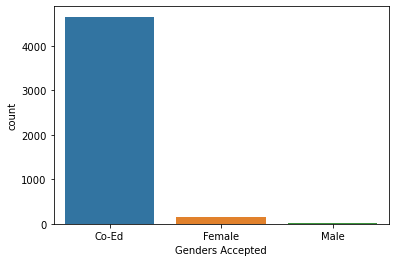

In [17]:
# getting the count of different genders accepted}
sns.countplot(data=engg_colleges, x=engg_colleges["Genders Accepted"])

### 3. Campus Size : Need to clean the column by removing the word acre after every value and convert the same into numerical column

In [18]:
# checking for null values
engg_colleges["Campus Size"].isna().sum()

2458

In [19]:
# replacing Acres / Acre with blank string and stripping out the spaces
engg_colleges["Campus Size"] = engg_colleges["Campus Size"].str.replace("Acres", "")
engg_colleges["Campus Size"] = engg_colleges["Campus Size"].str.replace("Acre", "")
engg_colleges["Campus Size"] = engg_colleges["Campus Size"].str.strip()

In [20]:
# converting the data types of the Campus size to float
engg_colleges["Campus Size"] = engg_colleges["Campus Size"].astype('float')

In [21]:
# checking the data type for Campus Size
engg_colleges["Campus Size"].dtype

dtype('float64')

In [22]:
# getting the overview of the data
engg_colleges["Campus Size"].describe()

count     2372.000000
mean        71.309865
std        358.368825
min          0.000000
25%         11.000000
50%         23.000000
75%         50.000000
max      16000.000000
Name: Campus Size, dtype: float64

### 4. Total Student Enrollments : This column is already clean and contains some null values

In [23]:
# checking for null values
engg_colleges["Total Student Enrollments"].isna().sum()

903

In [24]:
# checking the data type for Total Student Enrollments 
engg_colleges["Total Student Enrollments"].dtype

dtype('float64')

In [25]:
# getting the overview of the data
engg_colleges["Total Student Enrollments"].describe()

count    3.927000e+03
mean     2.048035e+03
std      1.957238e+04
min      1.000000e+00
25%      4.150000e+02
50%      8.360000e+02
75%      1.610500e+03
max      1.035081e+06
Name: Total Student Enrollments, dtype: float64

### 5. Total Faculty : This column is already clean and contains some null values

In [26]:
# checking for null values
engg_colleges["Total Faculty"].isna().sum()

143

In [27]:
# checking the data type for Total Faculty
engg_colleges["Total Faculty"].dtype

dtype('float64')

In [28]:
# getting the overview of the data
engg_colleges["Total Faculty"].describe()

count    4687.000000
mean      102.620226
std       118.255767
min         1.000000
25%        42.000000
50%        74.000000
75%       129.000000
max      2453.000000
Name: Total Faculty, dtype: float64

<AxesSubplot:xlabel='Total Faculty', ylabel='Count'>

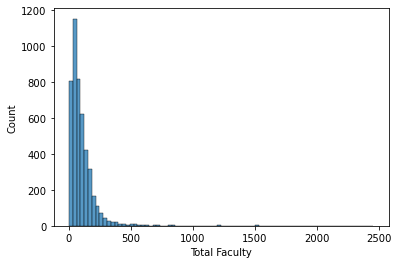

In [29]:
sns.histplot(data=engg_colleges["Total Faculty"], bins=80)

### 6. Established Year: This column is already clean and contains some null values

In [30]:
# checking for null values
engg_colleges["Established Year"].isna().sum()

95

In [31]:
# checking the data type for Established Year
engg_colleges["Established Year"].dtype

dtype('float64')

In [32]:
# getting the overview of the data
engg_colleges["Established Year"].describe()

count    4735.000000
mean     2000.954382
std        15.723504
min      1857.000000
25%      1999.000000
50%      2007.000000
75%      2009.000000
max      2019.000000
Name: Established Year, dtype: float64

<AxesSubplot:xlabel='Established Year', ylabel='Count'>

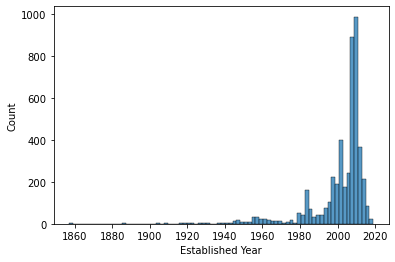

In [33]:
sns.histplot(data=engg_colleges["Established Year"], bins=80)

### 7. Rating: This column has almost all null values and has required data type

In [34]:
# checking for null values
engg_colleges["Rating"].isna().sum()

4510

In [35]:
# checking the data type for Rating
engg_colleges["Rating"].dtype

dtype('float64')

<AxesSubplot:xlabel='Rating', ylabel='Rating'>

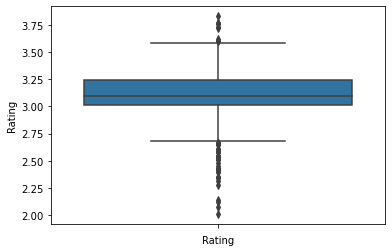

In [36]:
plt.xlabel("Rating")
sns.boxplot(data=engg_colleges["Rating"], y=engg_colleges["Rating"])

### 8. University: This column can be normalized into a different table and contains some null values

In [37]:
# checking for null values.
engg_colleges["University"].isna().sum()

1640

In [38]:
# getting the count of unique universities
f"There are {len(set(list(engg_colleges['University'])))} unique universities present"

'There are 185 unique universities present'

In [39]:
# getting the list of unique universities 
set(list(engg_colleges['University']))

{'APJ Abdul Kalam Technological University, Thiruvananthapuram',
 'Acharya NG Ranga Agricultural University, Guntur',
 'Acharya Nagarjuna University, Guntur',
 'Al Falah University, Faridabad',
 'Alliance University, Bangalore',
 'Amity University, Noida',
 'Amrita Vishwa Vidyapeetham, Coimbatore',
 'Andhra University, Visakhapatnam',
 'Anna University, Chennai',
 'Annamalai University, Annamalai Nagar',
 'Ansal University, Gurgaon',
 'Arni University, Kathgarh',
 'Aryabhatta Knowledge University, Patna',
 'Assam Don Bosco University, Guwahati',
 'Assam Science and Technology University, Guwahati',
 'Assam University, Silchar',
 'Atmiya University, Rajkot',
 'Baddi University of Emerging Sciences and Technology, Baddi',
 'Bangalore University, Bangalore',
 'Barkatullah University, Bhopal',
 'Bhabha University, Bhopal',
 'Bharati Vidyapeeth, Pune',
 'Bhupendra Narayan Mandal University, Madhepura',
 'Biju Patnaik University of Technology, Rourkela',
 'Bikaner Technical University, Bikan

<AxesSubplot:xlabel='count', ylabel='University'>

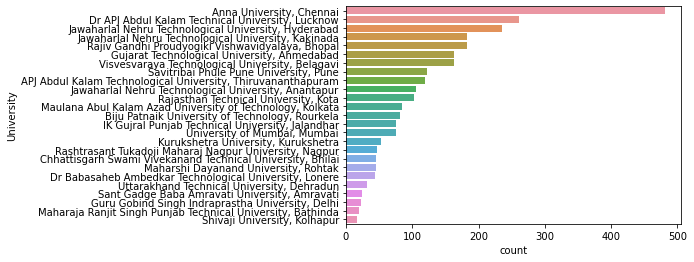

In [40]:
# plotting the top 25 university counts
sns.countplot(data=engg_colleges, y=engg_colleges["University"], order=engg_colleges.University.value_counts().iloc[:25].index)

### 9. Courses : This column contains comma separated values of all the courses that the specific university offers. This can be normalized into a different table and corresponding course values can be stored for specific college. 

In [41]:
engg_colleges["Courses"].isna().sum()

0

In [42]:
# splitting the comma separated courses 
courses = engg_colleges["Courses"].str.split(", ")

course_set = set()

# adding the unique courses in the course set.
for course_list in courses:
    for course in course_list:
        course_set.add(course)
        
course_set

{'M.Tech Pharma Pharmaceutical Technology Biotechnology',
 'Ph.D Criminology and Police Studies',
 'Diploma in Mechanical and Automobile Engineering',
 'M.V.Sc Veterinary Medicine',
 'Economics and Physics',
 'Ph.D Monsoon Studies',
 'M.Sc Naturopathy',
 'MBA Executive Financial Market',
 'M.Tech Biotechnology and Biochemical Engineering',
 'MBA Correspondence',
 'M.Phil Biomedical Engineering',
 'BA-Hindi Literature Sanskrit and Political Science',
 'M.Sc by Research Mathematics',
 'BFA Applied Arts',
 'B.Tech MBA Automobile Engineering Integrated',
 'MA Acharya',
 'B.Tech Computer Science and Engineering with Specialization in Augmented Reality and Virtual Reality',
 'Mechanical Engineering.',
 'Ph.D Social Sciences in Health',
 'M.Sc Biology Integrated',
 'B.Voc Sanitary Inspection',
 'B.Tech Nanotechnology',
 'B.Sc Cardiac Catherization Laboratory Technology',
 'Computer Science and Economics',
 'MD Physical Medicine and Rehabilitation',
 'B.Lib.Sc Self Finance Hons',
 'MS by Resea

### 10. Facilities : This column contains comma separated values of all the Facilities that a particular college offers. This can be normalized into a different table and the corresponding values can be stored for specific college. 

In [43]:
# getting the count of null values
engg_colleges["Facilities"].isna().sum()

12

In [44]:
# extracting the facilities for all the colleges
facilities = engg_colleges["Facilities"]

In [45]:
facility_dict = {}

for college_facility in facilities:
    if type(college_facility) != str:
        continue
        
    facility_list = college_facility.split(", ")
    for facility in facility_list:
        if facility not in facility_dict.keys():
            facility_dict[facility] = 1
        else:
            facility_dict[facility] += 1

facility_dict

{'Boys Hostel': 3738,
 'Girls Hostel': 3805,
 'Gym': 2594,
 'Library': 4798,
 'Sports': 4365,
 'Cafeteria': 3887,
 'Medical/Hospital': 3238,
 'Wifi': 2190,
 'IT Infrastructure': 4739,
 'Laboratories': 4232,
 'Swimming Pool': 182,
 'Convenience Store': 688,
 'Alumni Associations': 2408,
 'Guest Room': 1758,
 'Banks Facilities': 1134,
 'Auditorium': 3321,
 'Transport': 3108,
 'Classrooms': 354,
 'Parking Facility': 343,
 'Moot Court': 16}

In [46]:
# sorting the facility dictionary
sorted_facility_list = sorted(facility_dict.items(), key=lambda x:x[1], reverse=True)

# extracting the keys and values
keys = [x[0] for x in sorted_facility_list]
values = [x[1] for x in sorted_facility_list]

<AxesSubplot:>

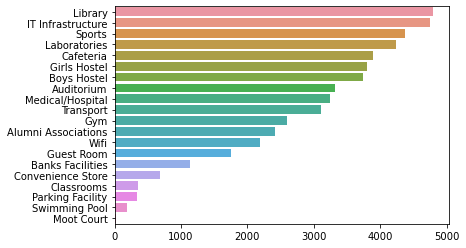

In [47]:
# drawing the bar plot
sns.barplot(x=values, y=keys)

### 11. City : This column contains city values for the corresponding colleges, and can be normalized into a different table.  

In [48]:
# checking for null values
engg_colleges["City"].isna().sum()

0

In [49]:
# getting the count of unique cities
f"There are {len(set(list(engg_colleges['City'])))} unique cities present"

'There are 2137 unique cities present'

In [50]:
# getting the list of unique cities
set(list(engg_colleges['City']))

{'Shahpur Kandi',
 'Turakapalle',
 'Murlipura at Mishra Ka Barh',
 'Kadammanitta',
 'Kalaiyur',
 'Bapatla',
 'Amarpur',
 'Thirumayam',
 'Khoraj',
 'Gadholi',
 'Thoothukudi',
 'Mewat',
 'Burdwan',
 'Faridkot',
 'Manehroo',
 'aganpur',
 'Malappuram',
 'Chandiprasad',
 'Thoothukudi (Tuticorin)',
 'Dera Bassi',
 'Mallasamudram',
 'Cheyyeru Gunnepalli',
 'Kochi',
 'Ammakulathupatti',
 'Gahana Govardhanpur',
 'Kalady',
 'Asangaon',
 'Cherpulassery',
 'Melapachchakudi',
 'Khatiwas',
 'Sirmour',
 'Edulabad',
 'Bir Hisar',
 'Pal',
 'Deoli',
 'Jalverhi Dhumi',
 'Latteri',
 'Rewari',
 'Guledagudda',
 'Raigad',
 'Mahurzari',
 'Purnea',
 'China Rajukuppam',
 'Bollikunta',
 'Athur',
 'Chhibramau',
 'Thuraiyur',
 'Poonjar',
 'Patha Tiruvuru',
 'Ballia',
 'Bhimtal',
 'Chalisgaon',
 'Sehore',
 'Athanur',
 'Kelende',
 'Kandukur',
 'Ranwan',
 'Shihi',
 'Thallampadu',
 'Mathra',
 'Tala',
 'Pandori',
 'Vembakottai',
 'Mummidivaram',
 'Chikkaballapura',
 'Karoli',
 'Marripalem',
 'Fulkumari Part',
 'Palampu

<AxesSubplot:xlabel='count', ylabel='City'>

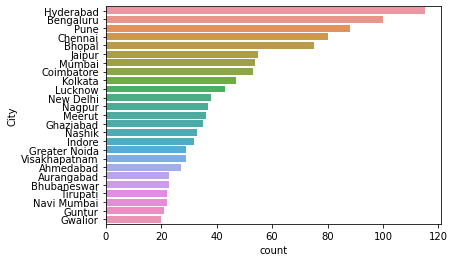

In [51]:
# Getting the top 25 cities containing most universities
sns.countplot(data=engg_colleges, y=engg_colleges["City"], order=engg_colleges.City.value_counts().iloc[:25].index)

### 12. State : This column contains state values for the corresponding colleges, and can be normalized into a different table.

In [52]:
# checking for null values
engg_colleges["State"].isna().sum()

0

In [53]:
# getting the count of unique cities
f"There are {len(set(list(engg_colleges['State'])))} unique states present"

'There are 34 unique states present'

In [54]:
# getting the list of unique States
set(list(engg_colleges['State']))

{'Andaman and Nicobar Islands',
 'Andhra Pradesh',
 'Arunachal Pradesh',
 'Assam',
 'Bihar',
 'Chandigarh',
 'Chhattisgarh',
 'Dadra and Nagar Haveli',
 'Delhi',
 'Goa',
 'Gujarat',
 'Haryana',
 'Himachal Pradesh',
 'Jammu and Kashmir',
 'Jharkhand',
 'Karnataka',
 'Kerala',
 'Madhya Pradesh',
 'Maharashtra',
 'Manipur',
 'Meghalaya',
 'Mizoram',
 'Nagaland',
 'Odisha',
 'Puducherry',
 'Punjab',
 'Rajasthan',
 'Sikkim',
 'Tamil Nadu',
 'Telangana',
 'Tripura',
 'Uttar Pradesh',
 'Uttarakhand',
 'West Bengal'}

<AxesSubplot:xlabel='count', ylabel='State'>

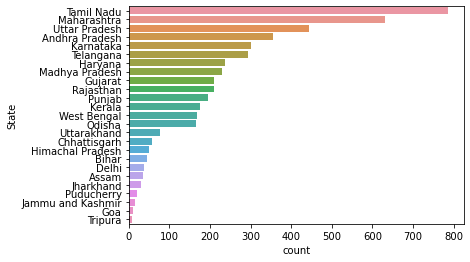

In [55]:
# top 25 states containing most universities
sns.countplot(data=engg_colleges, y=engg_colleges["State"], order=engg_colleges.State.value_counts().iloc[:25].index)

### 13. Country : This column contains only 1 value i.e India. We can create a new table to scale up the system and accomodate new countries

In [56]:
# checking for null values
engg_colleges["Country"].isna().sum()

0

In [57]:
# getting the count of unique country
f"There is {len(set(list(engg_colleges['Country'])))} unique country present"

'There is 1 unique country present'

In [58]:
# getting the list of unique Country
set(list(engg_colleges['Country']))

{'India'}

### 14. College Type : This column contains different college types and can be normalized to create a new table

In [59]:
# checking for null values
engg_colleges["College Type"].isna().sum()

1

In [60]:
# getting the count of unique college types
f"There are {len(set(list(engg_colleges['College Type'])))} unique college types present"

'There are 3 unique college types present'

In [61]:
# getting the list of unique college types
set(list(engg_colleges['College Type']))

{'Private', 'Public/Government', nan}

<AxesSubplot:xlabel='College Type', ylabel='count'>

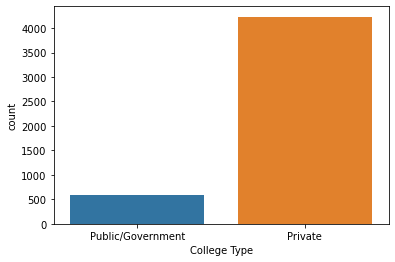

In [62]:
# count plot for colleges
sns.countplot(data=engg_colleges, x=engg_colleges["College Type"])

### 15. Average Fees : This column contains average fees for the colleges.

In [63]:
# checking for null values
engg_colleges["Average Fees"].isna().sum()

0

In [64]:
# getting the overview of the data
engg_colleges["Average Fees"].dtype

dtype('float64')

In [65]:
engg_colleges["Average Fees"].describe()

count    4.830000e+03
mean     1.945764e+05
std      1.778316e+05
min      3.000000e+02
25%      9.945854e+04
50%      1.600000e+05
75%      2.452497e+05
max      3.578597e+06
Name: Average Fees, dtype: float64

<AxesSubplot:xlabel='Average Fees', ylabel='Count'>

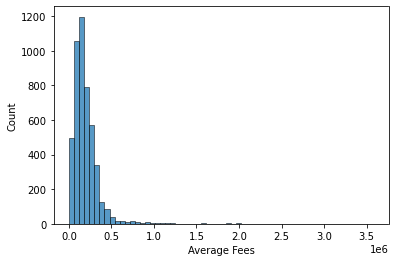

In [66]:
sns.histplot(data=engg_colleges["Average Fees"], bins=60)

## Inserting the data into the database

In [388]:
config = {
  'user': 'root',
  'password': 'root',
  'host': 'localhost',
  'port': 8889,
  'database': 'universities_database',
  'raise_on_warnings': True
}

In [389]:
universities_database = mysql.connector.connect(**config)

In [390]:
cursor = universities_database.cursor(dictionary=True)

In [391]:
# checking whether we are able to connect to the database
cursor.execute('SELECT * FROM user_details')

#This method fetches all rows of the query result set. 
myresult = cursor.fetchall()
print(myresult)

[{'user_id': 1, 'user_first_name': 'Shrirang', 'user_last_name': 'Mhalgi', 'email': 'shrirangmhalgi@gmail.com', 'password': 'root', 'mobile_number': 9876543201}, {'user_id': 2, 'user_first_name': 'Manali', 'user_last_name': 'Shelar', 'email': 'manalivs@gmail.com', 'password': 'manali', 'mobile_number': 9876543201}]


## inserting data into Facilities table

In [392]:
# populating the facilities table
for key in facility_dict.keys():
    query = f"insert into facilities (facility) values ('{key}')"
    cursor.execute(query)

print("successfully inserted data in the facility table")
universities_database.commit()

successfully inserted data in the facility table


In [393]:
# populating the college_type table
unique_college_types = set(list(engg_colleges['College Type']))

for college_type in unique_college_types:
    if type(college_type) == float:
        continue
    
    query = f"insert into college_type (college_type) values ('{college_type}')"
    cursor.execute(query)

print("successfully inserted data in the college_type table")
universities_database.commit()

successfully inserted data in the college_type table


In [394]:
# populating the indian_states table
indian_states = set(list(engg_colleges['State']))

for state in indian_states:
    query = f"insert into indian_states (state) values ('{state}')"
    cursor.execute(query)

print("successfully inserted data in the indian_states table")
universities_database.commit()

successfully inserted data in the indian_states table


In [395]:
# populating the indian_cities table 
indian_cities = set(list(engg_colleges['City']))

for city in indian_cities:
    query = f"insert into indian_cities (city) values ('{city}')"
    cursor.execute(query)

print("successfully inserted data in the indian_cities table")
universities_database.commit()

successfully inserted data in the indian_cities table


In [396]:
# populating the country table 
countries = {"United States of America", "India"}

for country in countries:
    query = f"insert into country (country_code, country_name) values ('', '{country}')"
    cursor.execute(query)

print("successfully inserted data in the country table")
universities_database.commit()

successfully inserted data in the country table


In [397]:
# populating the courses table 
for course in course_set:
    query = f'insert into courses (course_name) values ("{course}")'
    cursor.execute(query)

print("successfully inserted data in the courses table")
universities_database.commit()
    # engg_colleges.columns

successfully inserted data in the courses table


In [398]:
# populating the indian_universities table
indian_universities = set(list(engg_colleges['University']))

for university in indian_universities:
    query = f'insert into indian_universities (university_name) values ("{university}")'
    cursor.execute(query)

print("successfully inserted data in the indian_universities table")
universities_database.commit()

successfully inserted data in the indian_universities table


In [399]:
# populating the genders table
unique_genders = set(engg_colleges["Genders Accepted"])

for gender in unique_genders:
    if type(gender) == float:
        continue
    
    query = f"insert into genders (gender) values ('{gender}')"
    cursor.execute(query)

print("successfully inserted data in the genders table")
universities_database.commit()


successfully inserted data in the genders table


In [400]:
engg_colleges["Total Student Enrollments"] = engg_colleges["Total Student Enrollments"].fillna(-1)
engg_colleges["Campus Size"] = engg_colleges["Campus Size"].fillna(-1)
engg_colleges["Total Faculty"] = engg_colleges["Total Faculty"].fillna(-1)
engg_colleges["Established Year"] = engg_colleges["Established Year"].fillna(-1)
engg_colleges["Rating"] = engg_colleges["Rating"].fillna(-1)

In [401]:
# populating the indian_colleges table
for i in tqdm(range(len(engg_colleges))):
    # updating the college_name 
    college_name = engg_colleges.iloc[i]["College Name"]
    
    # updating the campus size
    campus_size = -1
    if engg_colleges.iloc[i]["Campus Size"] != None: 
        campus_size = engg_colleges.iloc[i]["Campus Size"]
    
    # updating the genders_accepted value
    genders_accepted = -1
    genders_accepted_query = f"select gender_id from genders where gender = '{engg_colleges.iloc[i]['Genders Accepted']}'" 
    cursor.execute(genders_accepted_query)
    myresult = cursor.fetchall()
    if len(myresult) != 0:
        genders_accepted = myresult[0]["gender_id"]
        
    # updating the total_student_enrollments value
    total_student_enrollments = -1
    if engg_colleges.iloc[i]["Total Student Enrollments"] != None:
        total_student_enrollments = engg_colleges.iloc[i]["Total Student Enrollments"] 
    
    # updating the total_faculty_count
    total_faculty_count = -1
    if engg_colleges.iloc[i]["Total Faculty"] != None:
        total_faculty_count = engg_colleges.iloc[i]["Total Faculty"] 
    
    # updating the established_year
    established_year = -1
    if engg_colleges.iloc[i]["Established Year"] != None:
        established_year = engg_colleges.iloc[i]["Established Year"] 
    
    # updating the rating 
    rating = -1
    if engg_colleges.iloc[i]["Rating"] != None:
        rating = engg_colleges.iloc[i]["Rating"]
    
    # updating the university_id
    university_id = -1
    university_id_query = f'select university_id from indian_universities where university_name = "{engg_colleges.iloc[i]["University"]}"' 
    cursor.execute(university_id_query)
    myresult = cursor.fetchall()
    university_id = myresult[0]["university_id"]
    
    # updating the courses
    courses = ''
    courses_str = engg_colleges.iloc[i]["Courses"]
    if type(courses_str) != float:
        courses_list = courses_str.split(', ')
        for course in courses_list:
            course_query = f'select course_id from courses where course_name = "{course}"' 
            cursor.execute(course_query)
            myresult = cursor.fetchall()
            courses += f'{myresult[0]["course_id"]},'
    
        courses = courses[:-1]
        
    
    # updating the facilities
    facilities = ''
    facs = engg_colleges.iloc[i]["Facilities"]
    if type(facs) != float:
        facilities_list = facs.split(', ')
        for facility in facilities_list:
            facility_query = f'select facility_id from facilities where facility = "{facility}"' 
            cursor.execute(facility_query)
            myresult = cursor.fetchall()
            facilities += f'{myresult[0]["facility_id"]},'
    
        facilities = facilities[:-1]
    
    # updating the city_id
    city_id = -1
    city_query = f'select city_id from indian_cities where city = "{engg_colleges.iloc[i]["City"]}"' 
    cursor.execute(city_query)
    myresult = cursor.fetchall()
    city_id = myresult[0]["city_id"]
    
    # updating the state_id
    state_id = -1
    state_query = f'select state_id from indian_states where state = "{engg_colleges.iloc[i]["State"]}"' 
    cursor.execute(state_query)
    myresult = cursor.fetchall()
    state_id = myresult[0]["state_id"]
    
    # updating the country_id
    country_id = 1
    
    # updating the college_type_id
    college_type_id = -1
    college_type_query = f'select college_type_id from college_type where college_type = "{engg_colleges.iloc[i]["College Type"]}"' 
    cursor.execute(college_type_query)
    myresult = cursor.fetchall()
    if len(myresult) != 0:
        college_type_id = myresult[0]["college_type_id"]
    
    # updating the average_fees
    average_fees = -1
    if engg_colleges.iloc[i]["Average Fees"] != None:
        average_fees = engg_colleges.iloc[i]["Average Fees"]
    
    
    # writing the insert query for the indian_colleges
    insert_query = f"""insert into indian_colleges (college_name, campus_size, gender_id, total_student_enrollments, total_faculty_count, established_year, rating, university_id, courses, facilities, city_id, state_id,  country_id, college_type_id, average_fees)  
                                values("{college_name}",
                                       {campus_size},
                                       {genders_accepted},
                                       {total_student_enrollments},
                                       {total_faculty_count},
                                       {established_year},
                                       {rating},
                                       {university_id},
                                       '{courses}',
                                       '{facilities}',
                                       {city_id},
                                       {state_id},
                                       {country_id},
                                       {college_type_id},
                                       {average_fees}
                                        )
    """
#     print(genders_accepted)
    cursor.execute(insert_query)
    

universities_database.commit()
print("successfully inserted data into indian_colleges")


100%|███████████████████████████████████████| 4830/4830 [06:25<00:00, 12.51it/s]

successfully inserted data into indian_colleges
